### **EXP1 Predicitng Missing Cell-Types from Bulks using Non-Negative Least Squares regression Residual**

*This file includes EXP1 specifics (outlined below), as well as the data preprocessing, QC, and creates the pseudobulks used in other experiments.*

Code based on:
1. https://github.com/nrosed/sc_bulk_ood/blob/main/sc_preprocessing/2_make_pseudobulks/scanpy_sc_preprocess_pbmc6k.ipynb
2. https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html

**Data Details:**

Data downloaded from: https://www.10xgenomics.com/resources/datasets/3-k-pbm-cs-from-a-healthy-donor-1-standard-1-0-0 PBMC 3K, Organism: Homo sapiens, Characteristics	tissue: blood

**Summary:** 

Preprocessing single-cell data from PBMC3k follwing Scanpy's tutorial. Pseudobulks are created for deconvolution by generating a random proportion vector, and defining the total number of cells per bulk as 5000. Creating 1000 realistic-proportions pseudobulks in 10 separate files with each file containing 1000 bulks. 

*This file can be run one kernel at a time, or all at once*

In [57]:
# import the dependencies
import sys
sys.path.insert(1, '../../')
sys.path.insert(1, '../')
sys.path.insert(1, '../../../../../')

from functions import sn_sc_preprocess
from functions import validation_processing as vp
from importlib import reload
reload(sn_sc_preprocess)
reload(vp)
# general imports
import warnings
import numpy as np
from numpy import random
import pandas as pd
import scanpy as sc
from anndata import AnnData as ad
from tabulate import tabulate

import scipy as sp
from scipy.stats import spearmanr, pearsonr
from scipy.sparse import coo_matrix
from scipy.sparse import csr_matrix
import scipy.stats as stats
from scipy.spatial.distance import euclidean
from collections import Counter
import scipy as sp
from scipy.optimize import nnls
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, dendrogram

# Images, plots, display, and visualization
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
import seaborn as sns
import umap
from sklearn.utils import resample
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# programming stuff
import time
import os, sys
import pickle
from pathlib import Path

In [58]:
#####################
### set the study ###
#####################

#results paths:
res_name = "MCT_pbmc_EXP1"
actual_path = os.getcwd()
path = f"{actual_path}/../data/"
aug_data_path = f"{actual_path}/../data/EXP1/"
cibersort_path = f"{aug_data_path}/cibersort/"
adata_path = f"{actual_path}/../data/"

# If you want pseudobulks to be made, change to True before running:
make_pseudos = False
#to extract genes
prep_cibersort = False
#If running CIBERSORTx in web (not Docker) file becomes too large
#so select True to limit cells per cell type.
limit_celltypes = False
cell_types_to_limit = []
max_cells_per_type = 550

**Reading in all the data:**

In [59]:
data_path = f"{aug_data_path}/filtered_gene_bc_matrices/hg19/"
#adata containing count matrix
adata = sc.read_10x_mtx(data_path, var_names='gene_symbols', cache = True)
adata

... reading from cache file cache/Users-ivicha-Documents-pred_missing_celltypes-preprocessing-..-data-EXP1-filtered_gene_bc_matrices-hg19-matrix.h5ad


AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

## **QC of count matrix:**

Based on:
Scanpy https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html

In [60]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')
adata.var_names_make_unique() 

scanpy==1.9.3 anndata==0.7.8 umap==0.5.3 numpy==1.20.3 scipy==1.7.1 pandas==1.3.3 scikit-learn==1.0.2 statsmodels==0.13.0 python-igraph==0.9.9 pynndescent==0.5.10


normalizing counts per cell
    finished (0:00:00)


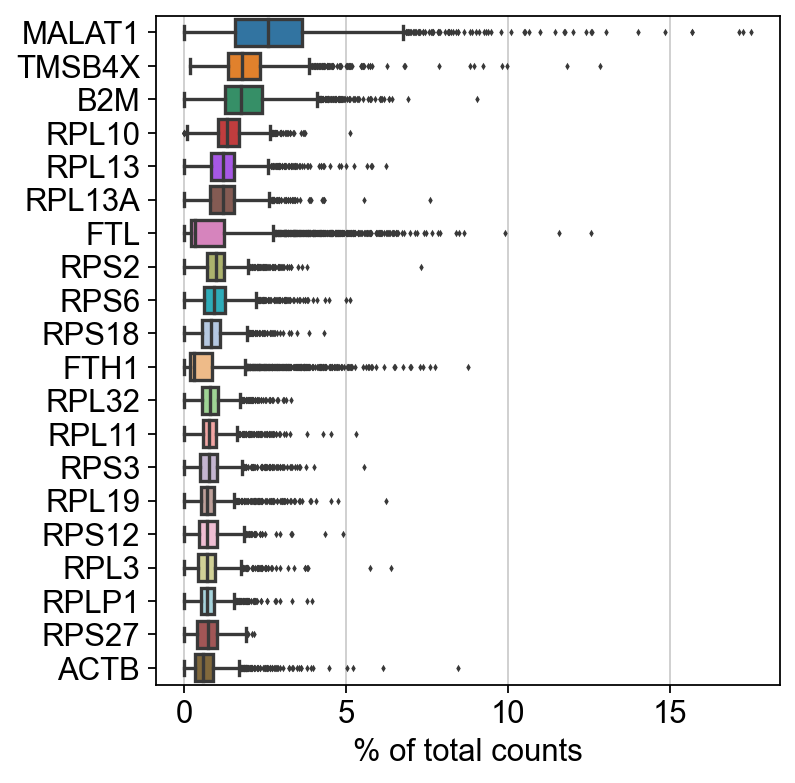

In [61]:
sc.pl.highest_expr_genes(adata, n_top=20, )

Basic Filtering:

In [62]:
#filtering genes present in less than 3 cells:
#and cells with less than 200 genes
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 19024 genes that are detected in less than 3 cells


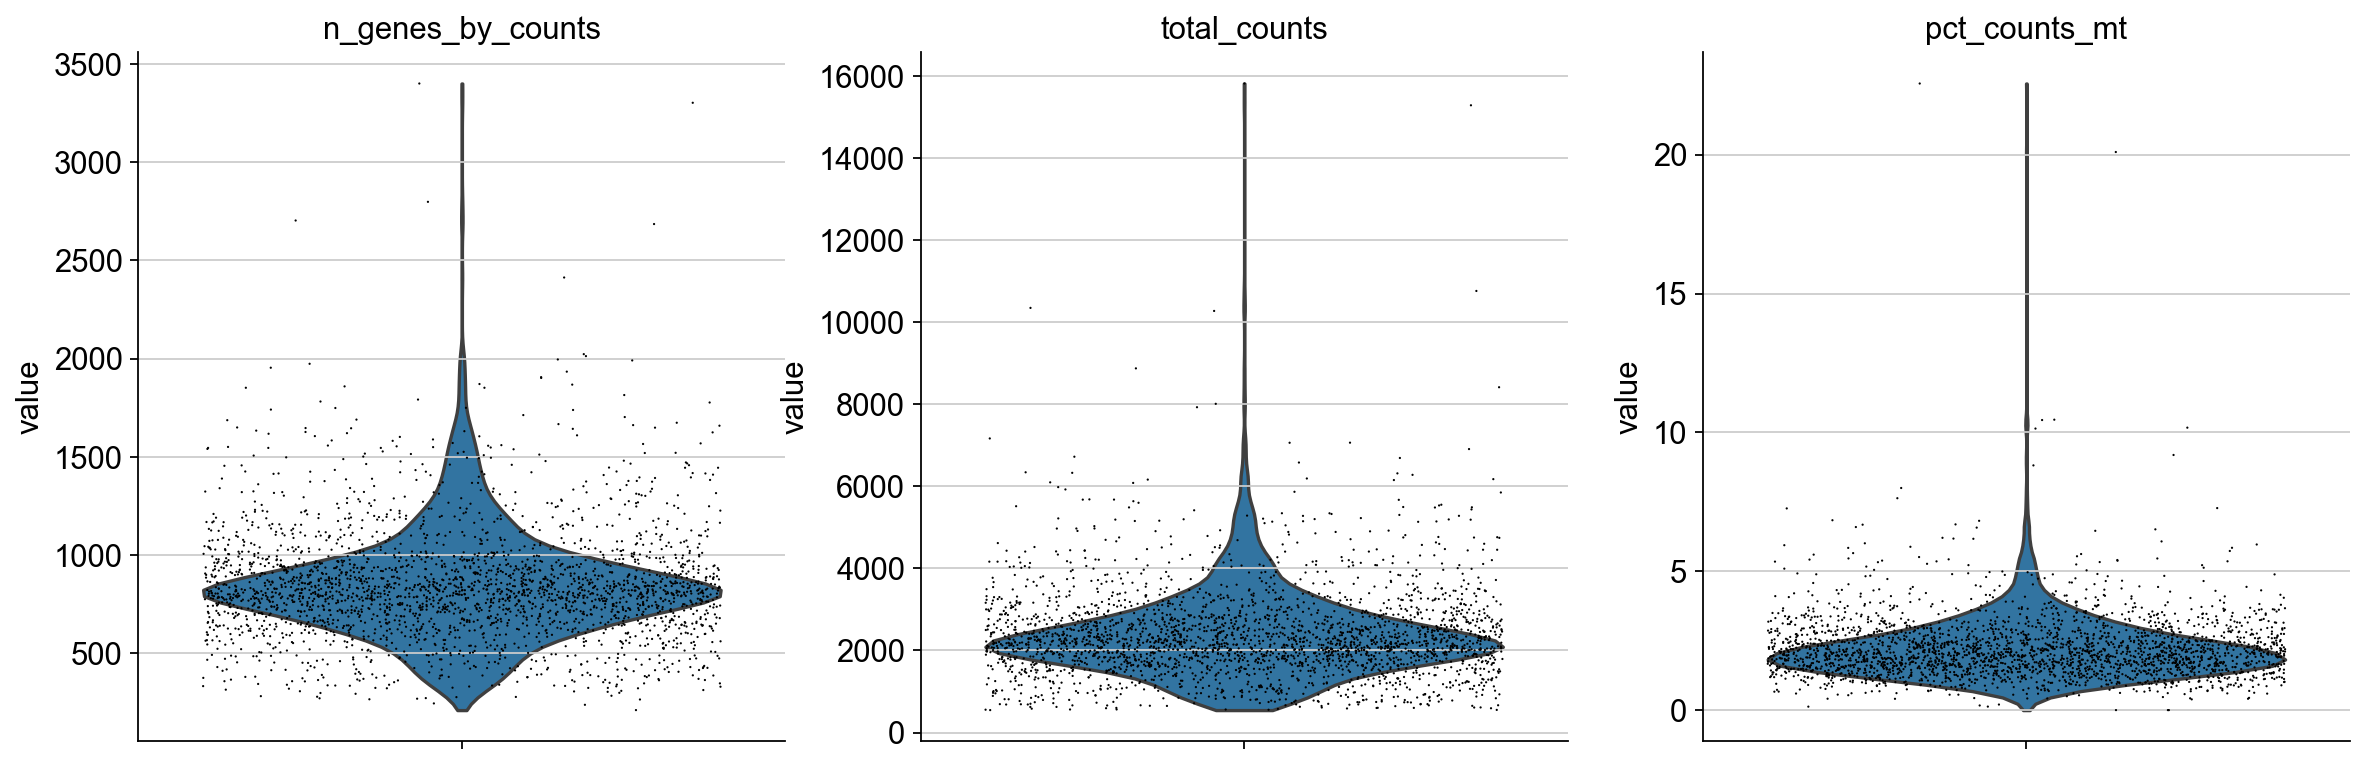

In [63]:
# mitochondrial genes
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

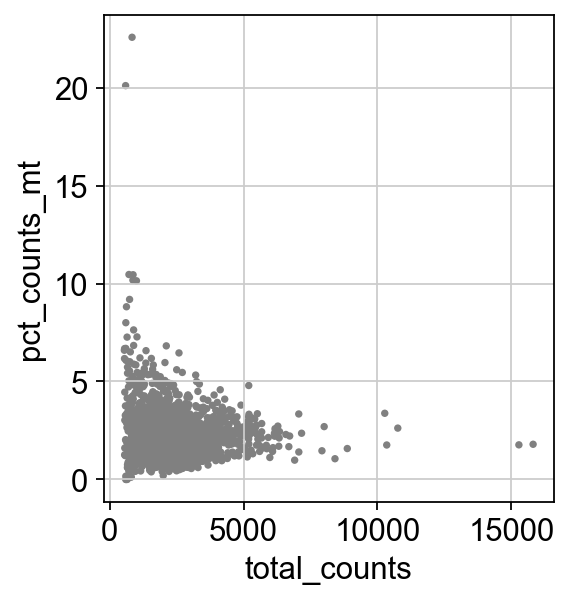

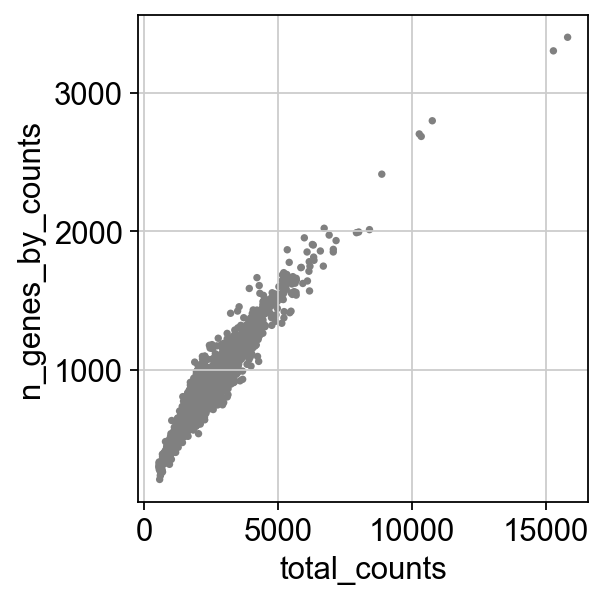

In [64]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

Filtering

In [65]:
# slice the data based on the plots from above
# remove cells with more than 2500 genes
# remove cells with more than 5% MTgenes
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

In [66]:
#making copy to keep unnormalized for pseudobulks as counts:
adata_copy = adata.copy()

normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes


/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


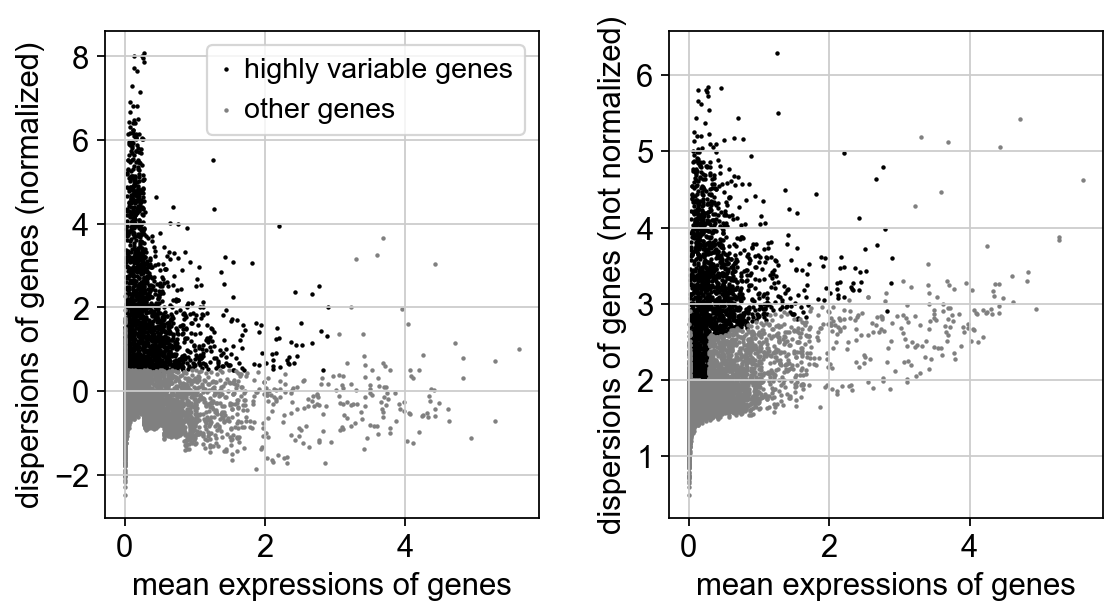

In [67]:
# normalize to 10K counts per cell
sc.pp.normalize_total(adata, target_sum=1e4)

# log data
sc.pp.log1p(adata)

# get high variance genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

# and plot
sc.pl.highly_variable_genes(adata)

In [68]:
# now process the counts further and filtering
adata.raw = adata
adata = adata[:, adata.var.highly_variable]

# regress out the signal
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

# scale the genes
sc.pp.scale(adata, max_value=10)

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:09)


PCA

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


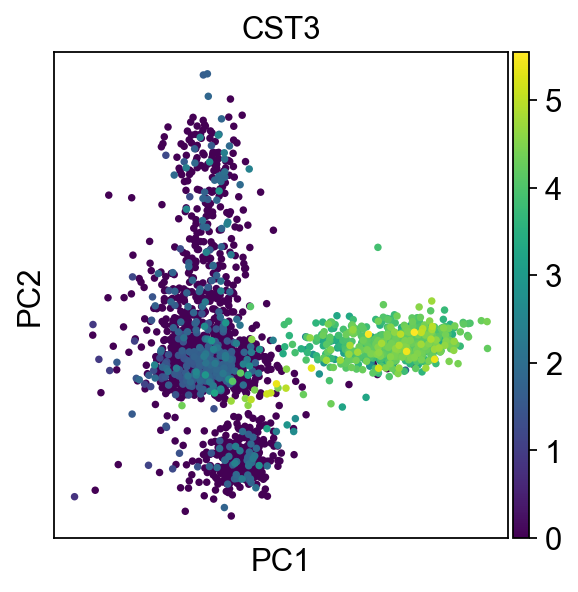

In [69]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca(adata, color='CST3')

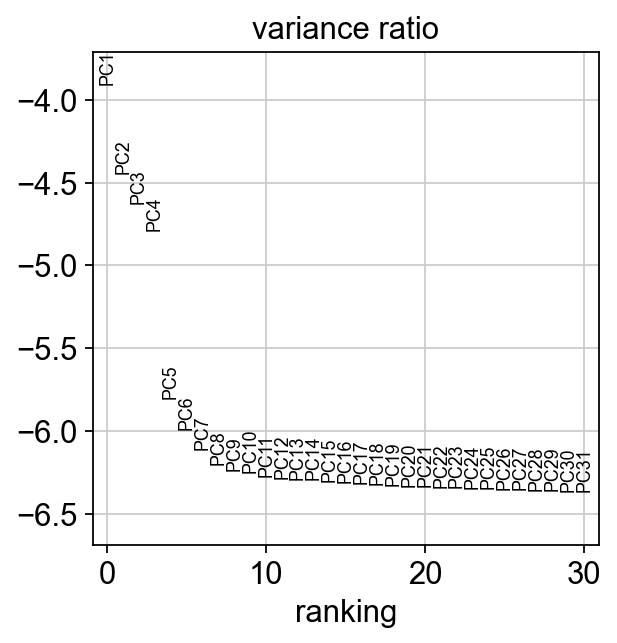

In [70]:
sc.pl.pca_variance_ratio(adata, log=True)

Compute and embedd neighborhood graph

In [71]:
# calculate neighborhood graph
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

sc.tl.leiden(adata)
sc.tl.paga(adata)
sc.pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])


computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:03)


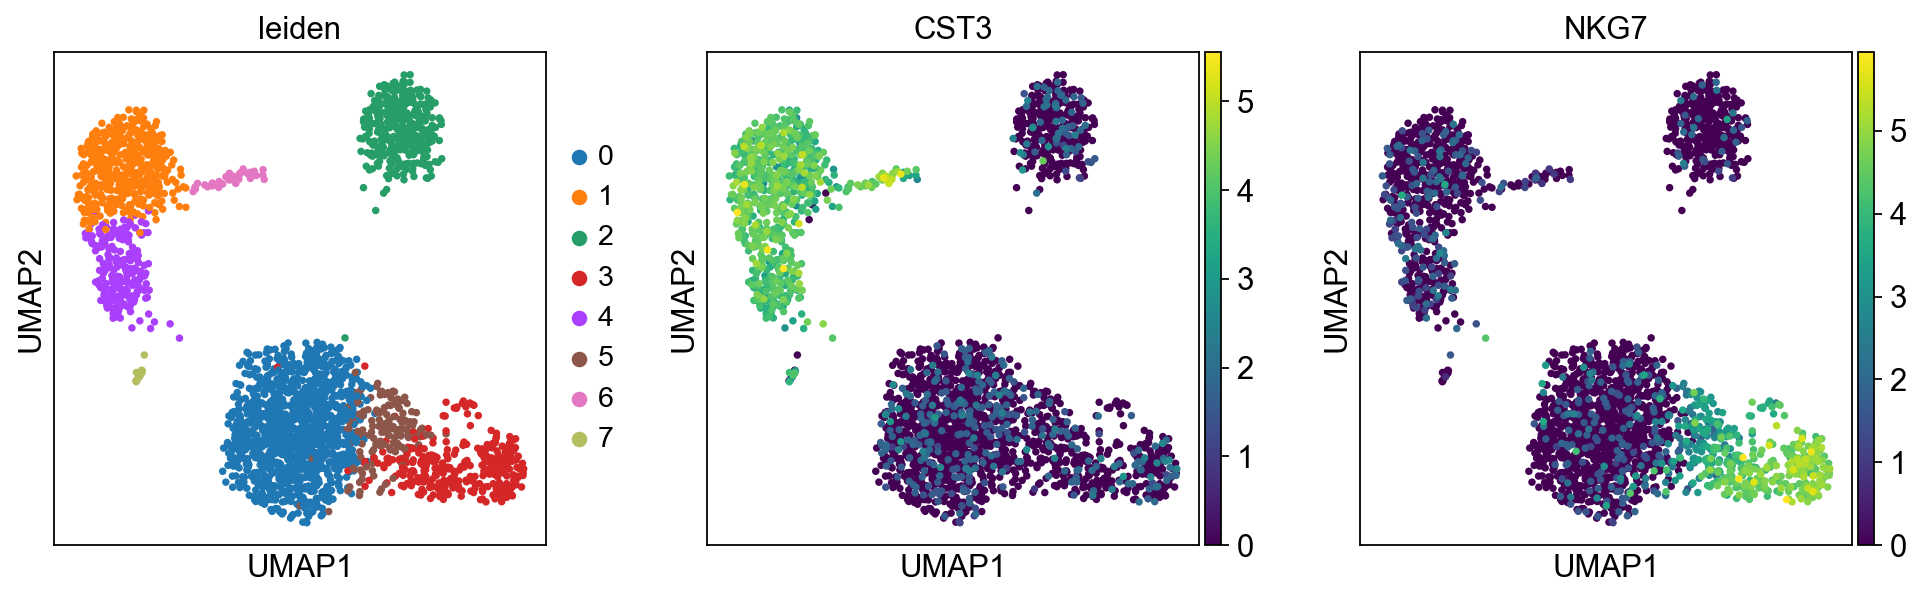

In [72]:
sc.tl.umap(adata, init_pos='paga')
sc.pl.umap(adata, color=['leiden', 'CST3', 'NKG7'])

Finding Marker Genes:

In [73]:
sc.settings.verbosity = 2  # reduce the verbosity

ranking genes
    finished (0:00:01)


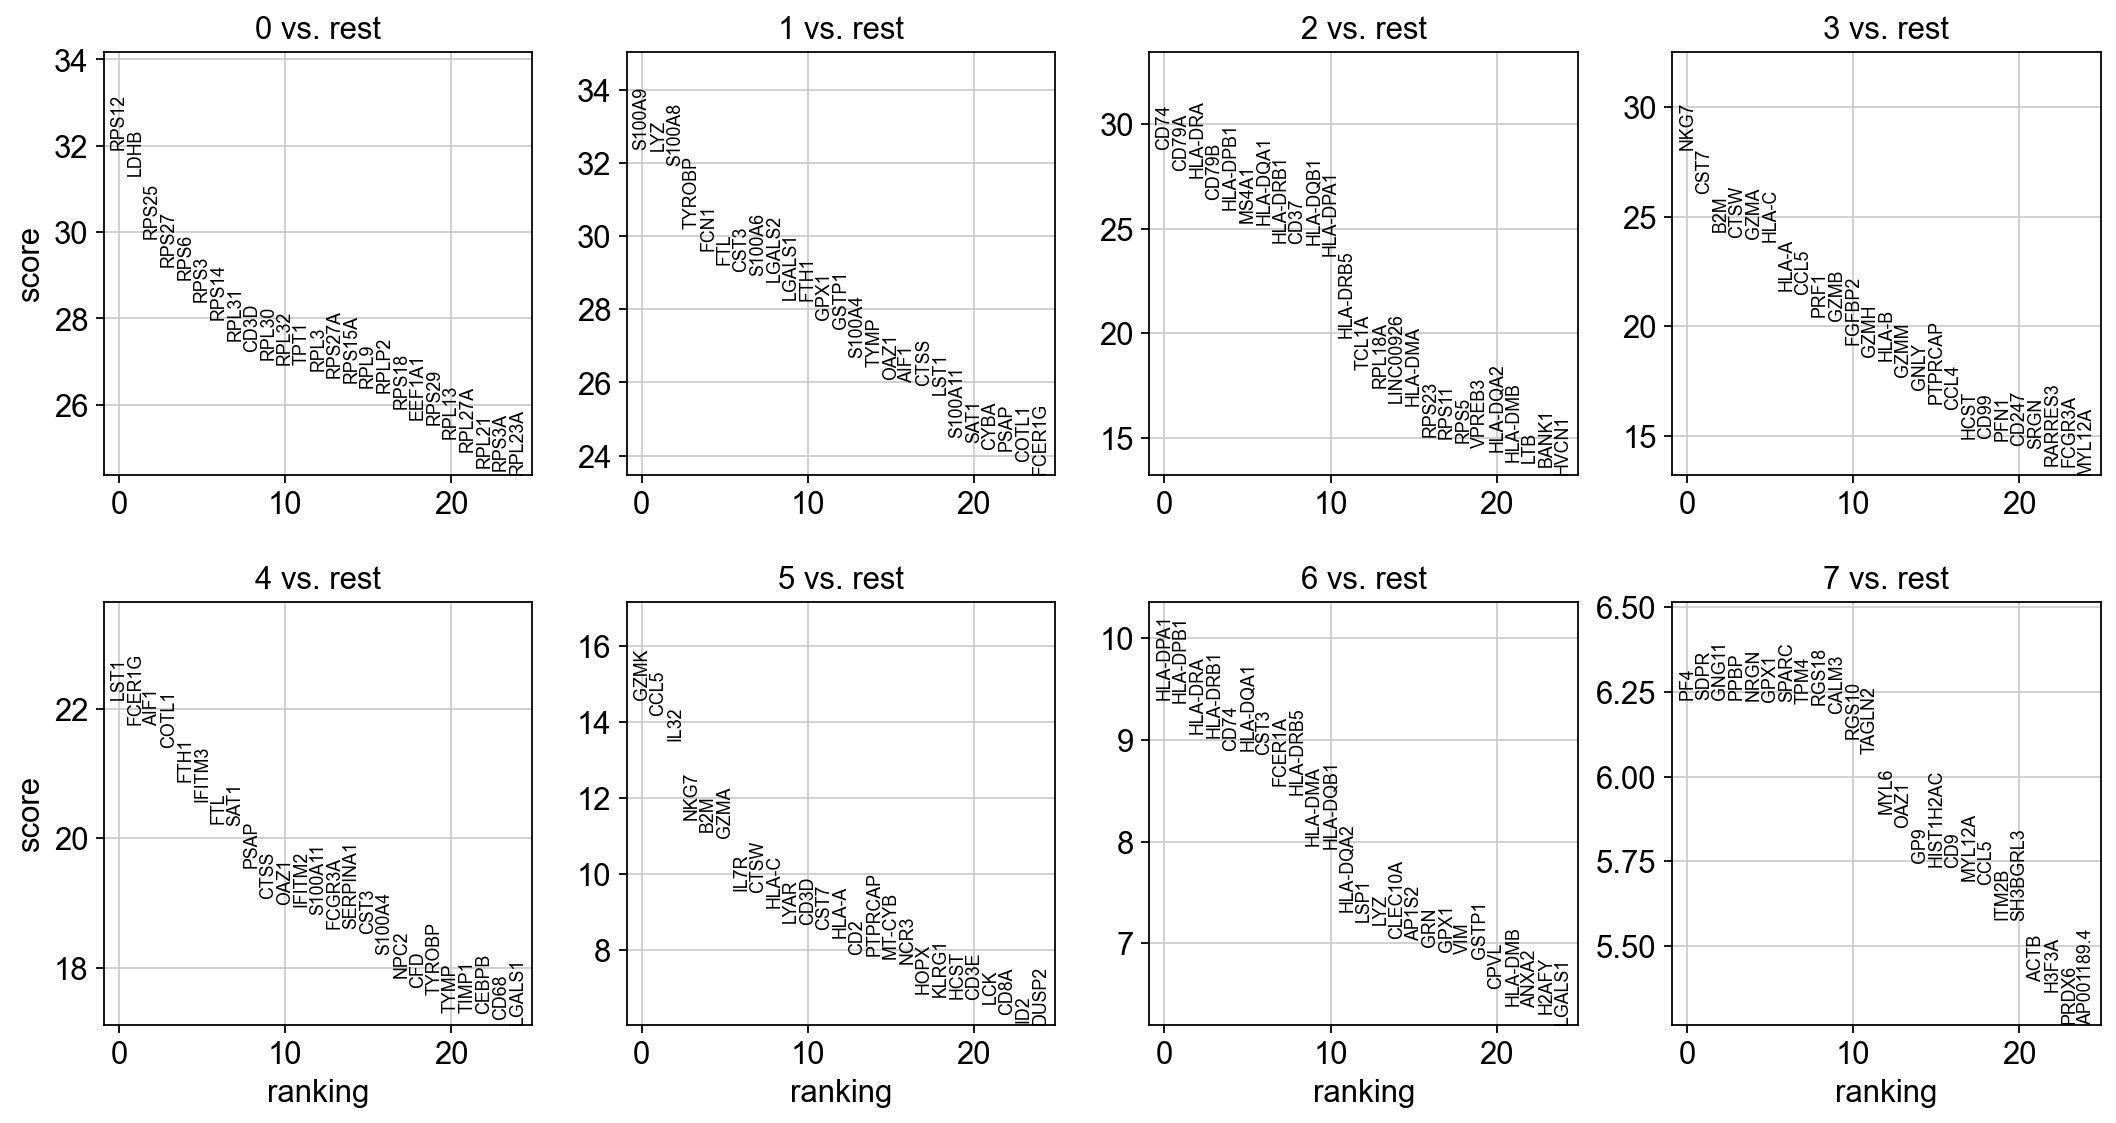

In [74]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

ranking genes
    finished (0:00:02)


/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


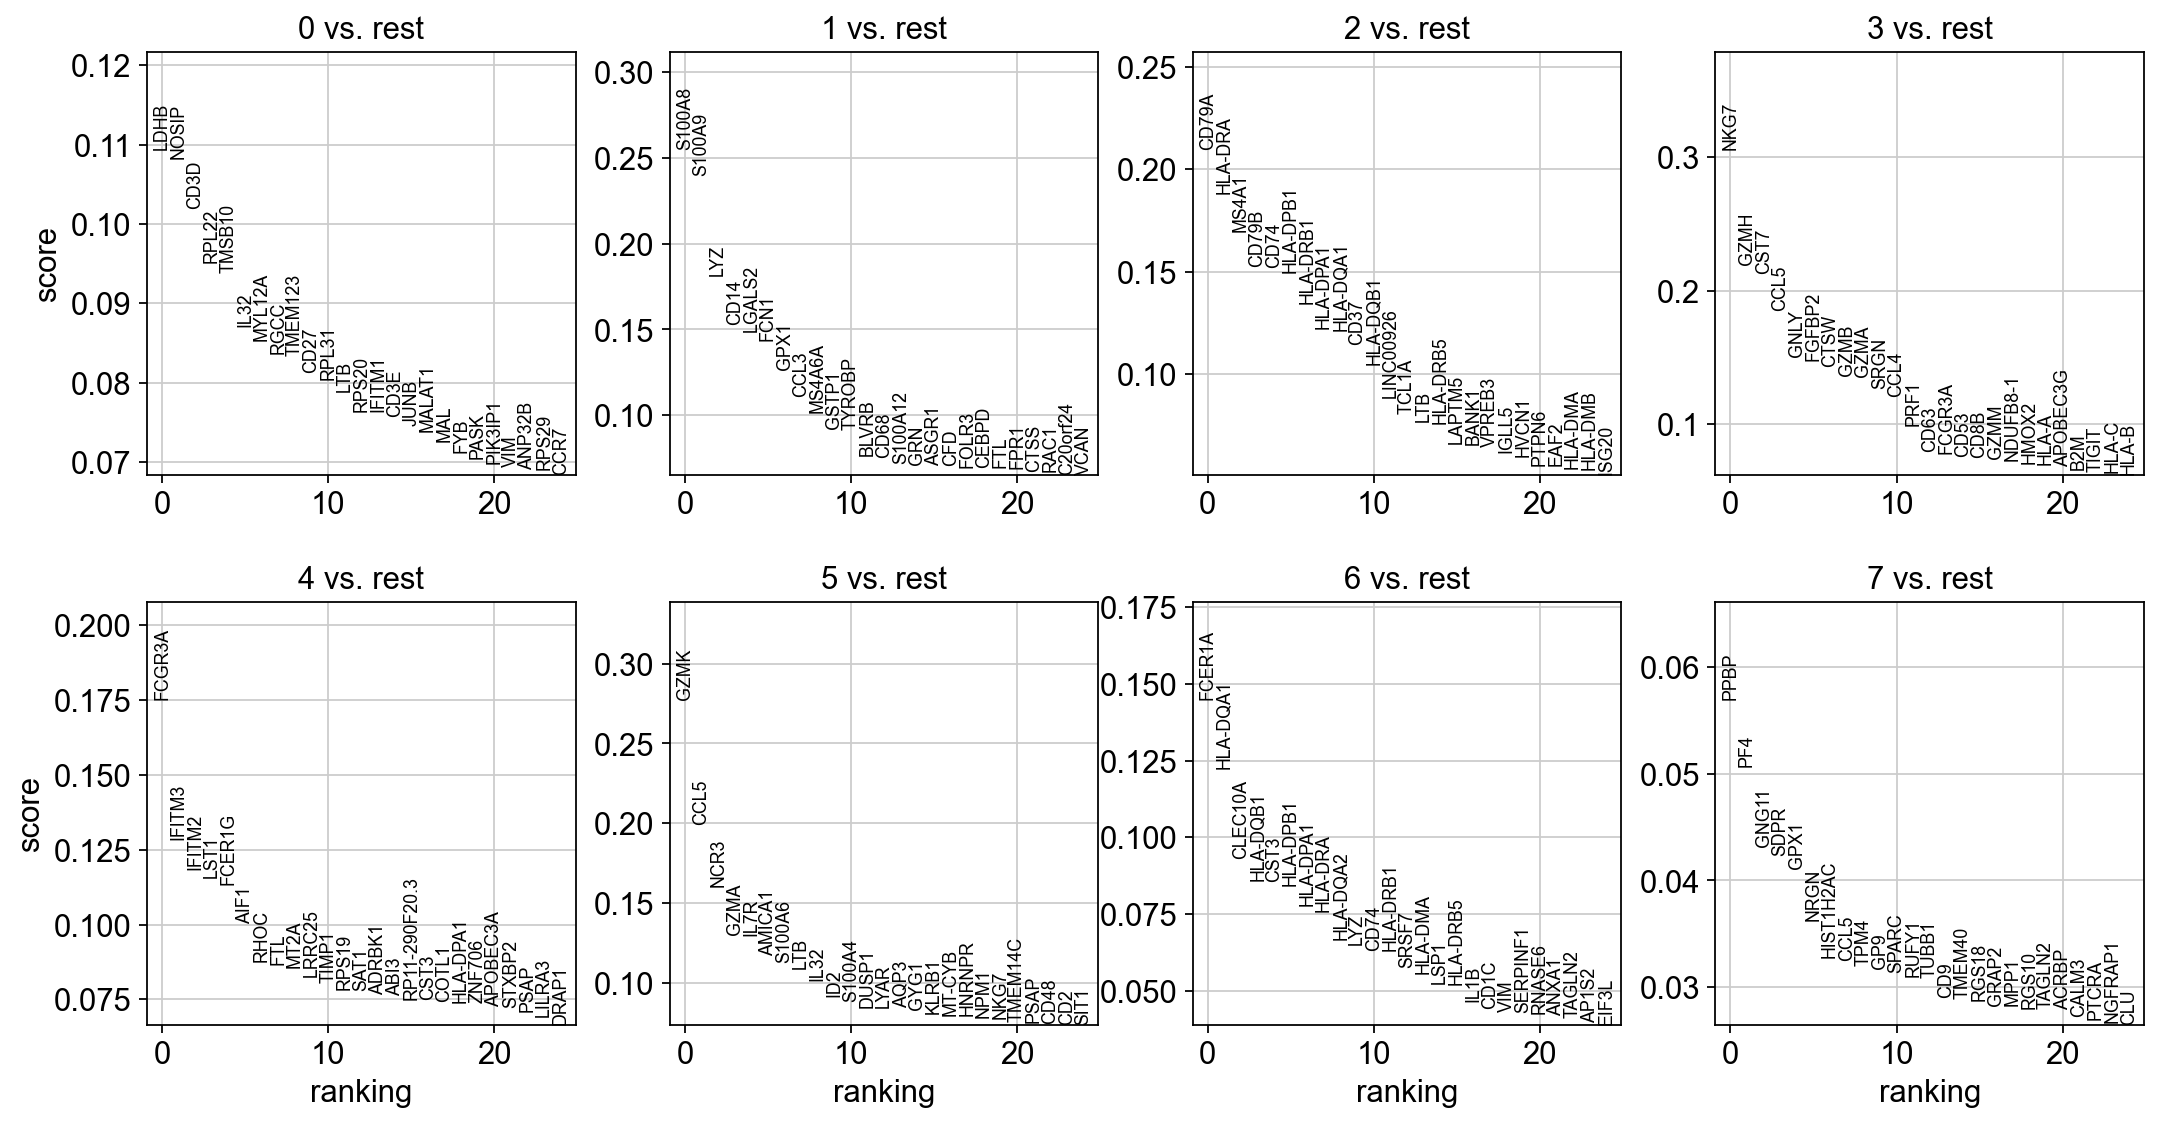

In [75]:
sc.tl.rank_genes_groups(adata, 'leiden', method='logreg')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

Let us also define a list of marker genes for later reference.

In [76]:
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']

In [77]:
#recovering unnormalized anndata
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

0       1        2     3       4     5         6      7
0    LDHB  S100A8    CD79A  NKG7  FCGR3A  GZMK    FCER1A   PPBP
1   NOSIP  S100A9  HLA-DRA  GZMH  IFITM3  CCL5  HLA-DQA1    PF4
2    CD3D     LYZ    MS4A1  CST7  IFITM2  NCR3   CLEC10A  GNG11
3   RPL22    CD14    CD79B  CCL5    LST1  GZMA  HLA-DQB1   SDPR
4  TMSB10  LGALS2     CD74  GNLY  FCER1G  IL7R      CST3   GPX1

Compare to a single cluster:

ranking genes
    finished (0:00:00)


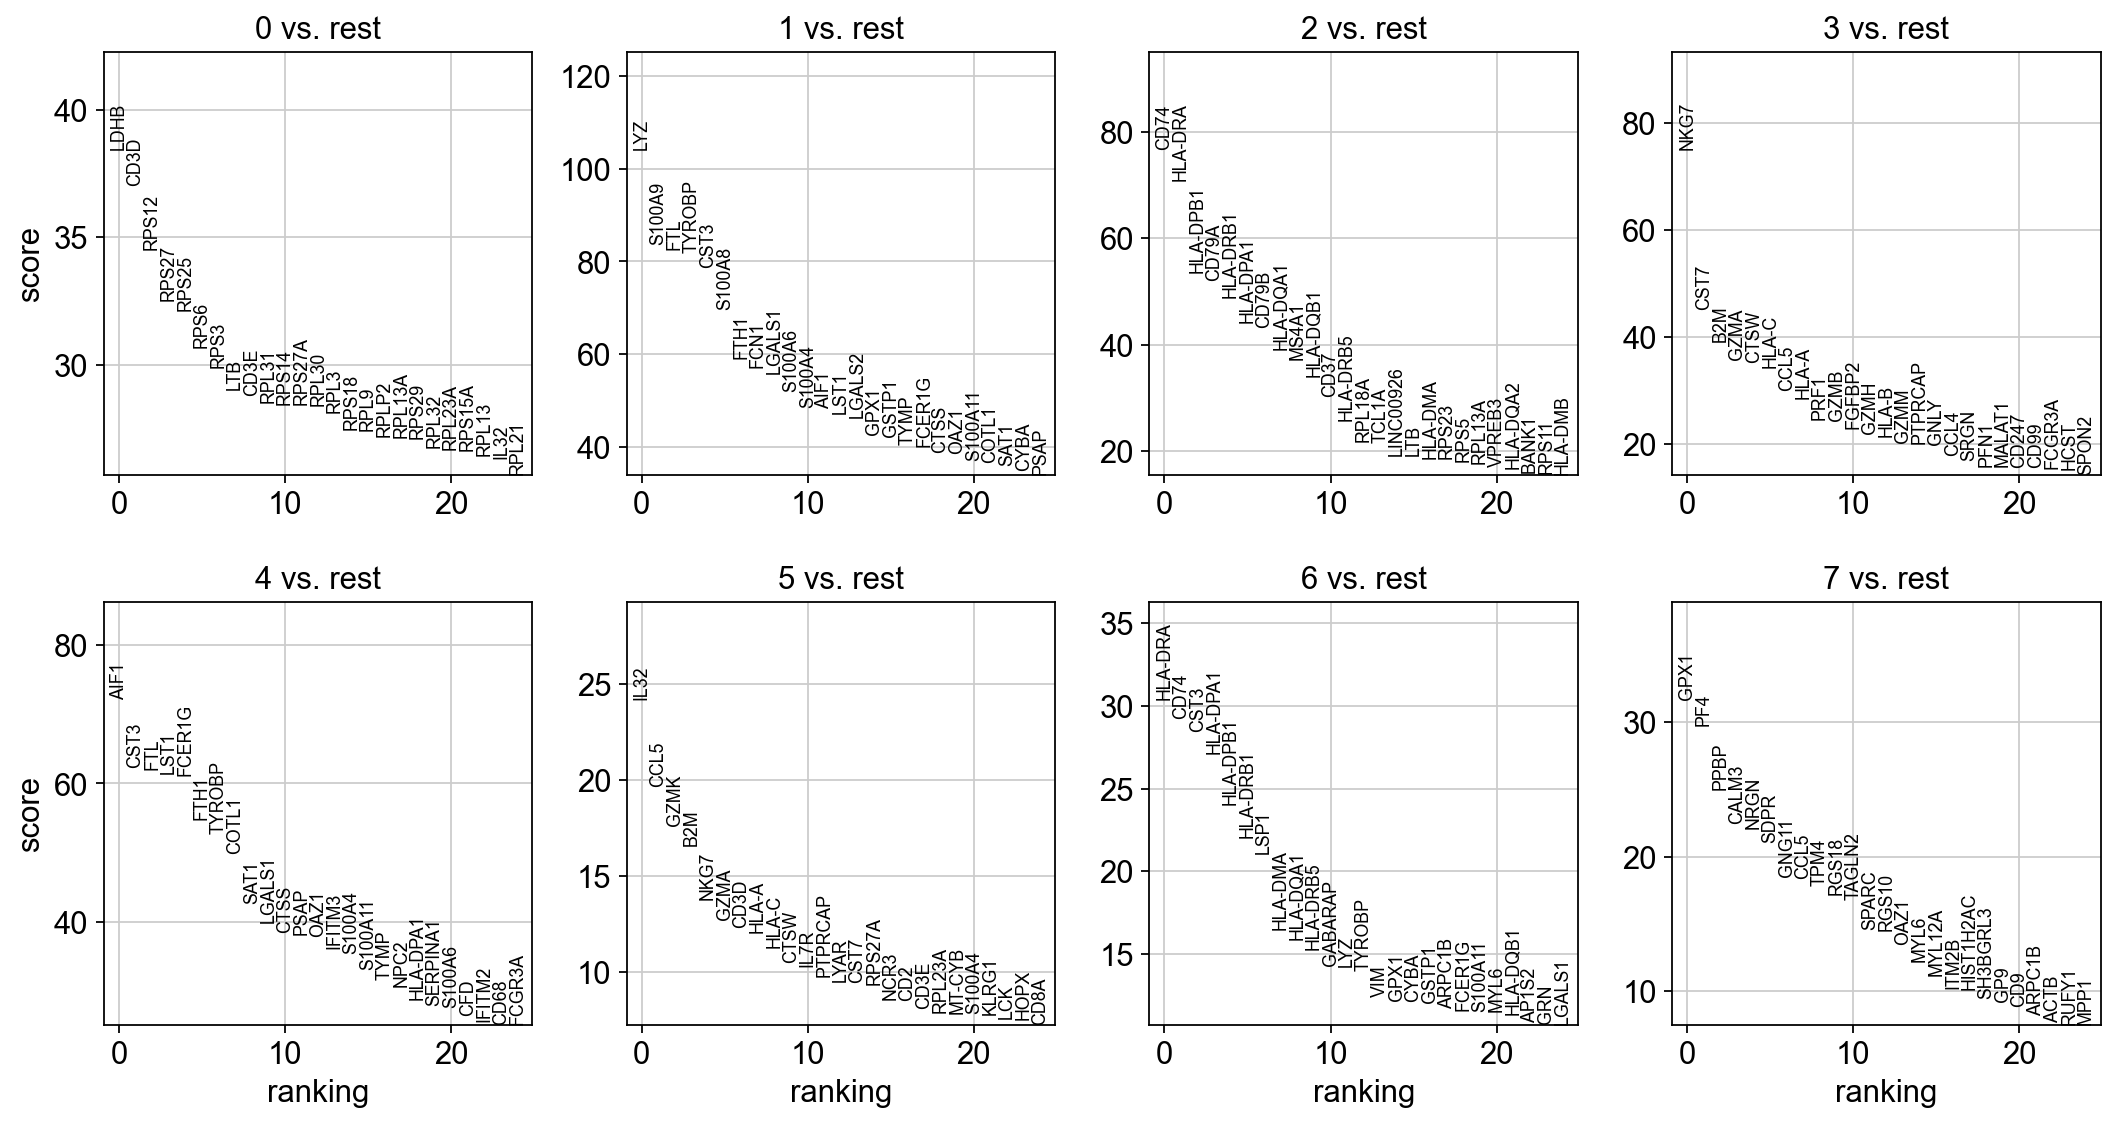

In [78]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [79]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

0_n            0_p     1_n  1_p       2_n            2_p   3_n  \
0   LDHB  6.738307e-257     LYZ  0.0      CD74   0.000000e+00  NKG7   
1   CD3D  5.434050e-241  S100A9  0.0   HLA-DRA   0.000000e+00  CST7   
2  RPS12  2.296645e-211     FTL  0.0  HLA-DPB1  2.421135e-269   B2M   
3  RPS27  7.361989e-192  TYROBP  0.0     CD79A  4.944394e-168  GZMA   
4  RPS25  1.641513e-188    CST3  0.0  HLA-DRB1  8.957978e-242  CTSW   

             3_p     4_n            4_p   5_n           5_p       6_n  \
0  1.812316e-244    AIF1  3.061068e-293  IL32  1.001296e-66   HLA-DRA   
1  1.085852e-147    CST3  1.845477e-290  CCL5  2.541176e-47      CD74   
2  8.506920e-165     FTL  3.724761e-268  GZMK  4.643399e-40      CST3   
3  7.737807e-119    LST1  4.555887e-193   B2M  8.697694e-42  HLA-DPA1   
4  8.942505e-121  FCER1G  8.138363e-210  NKG7  1.728441e-30  HLA-DPB1   

            6_p    7_n           7_p  
0  6.560267e-32   GPX1  1.326433e-13  
1  2.552722e-31    PF4  1.251720e-12  
2  2.601737e-29   PPBP  9.925949e-12  
3  4.913539e-28  CALM3  1.688225e-11  
4  2.866570e-25   NRGN  4.092874e-11

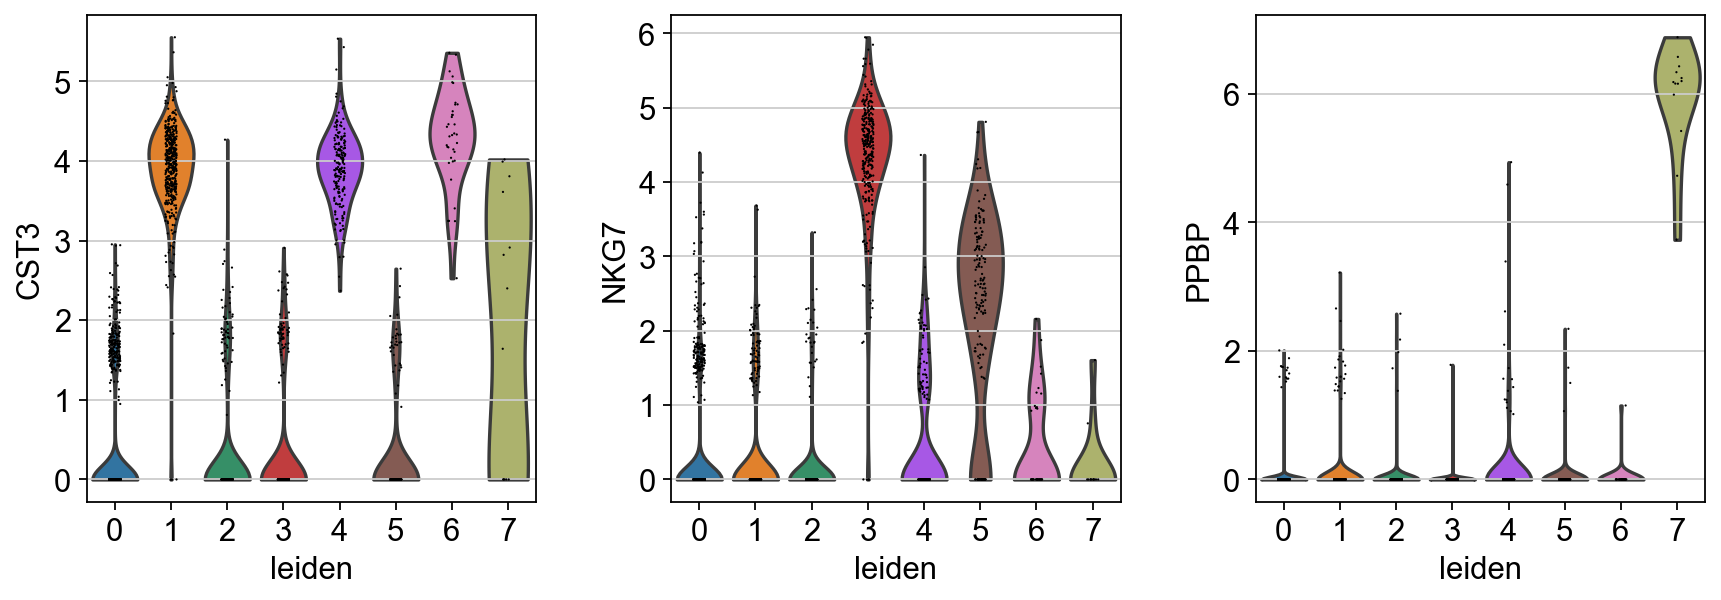

In [82]:
sc.pl.violin(adata, ['CST3', 'NKG7', 'PPBP'], groupby='leiden')

Actually mark the cell types.

/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2630: FutureWarning: The `inplace` parameter in pandas.Categorical.rename_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)
Omitting rank_genes_groups/names as old categories do not match.
Omitting rank_genes_groups/scores as old categories do not match.
Omitting rank_genes_groups/pvals as old categories do not match.
Omitting rank_genes_groups/pvals_adj as old categories do not match.
Omitting rank_genes_groups/logfoldchanges as old categories do not match.


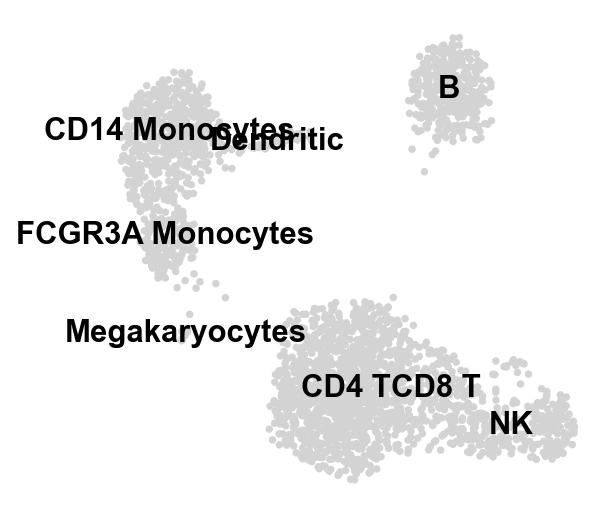

In [83]:
new_cluster_names = [
    'CD4 T', 'CD14 Monocytes',
    'B', 'NK', 
    'FCGR3A Monocytes', 'CD8 T',
    'Dendritic', 'Megakaryocytes']
adata.rename_categories('leiden', new_cluster_names)

#and plot
sc.pl.umap(
    adata, color="leiden", legend_loc="on data", title="", frameon=False, save=".pdf"
)

Now that we annotated the cell types, let us visualize the marker genes.

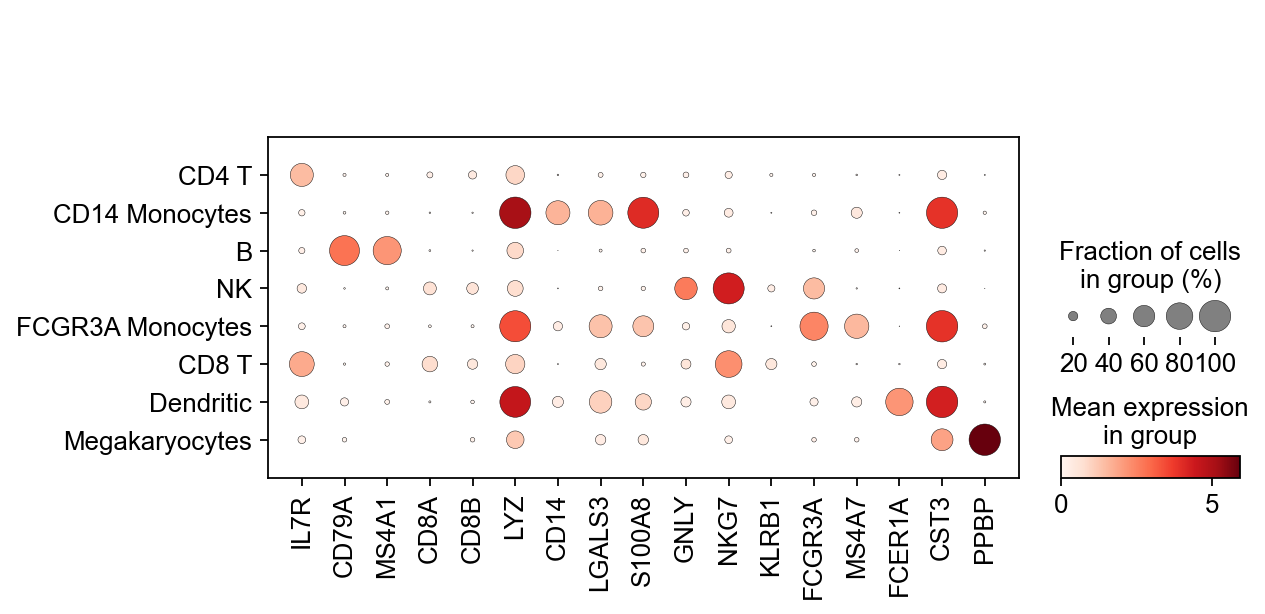

In [84]:
sc.pl.dotplot(adata, marker_genes, groupby='leiden')

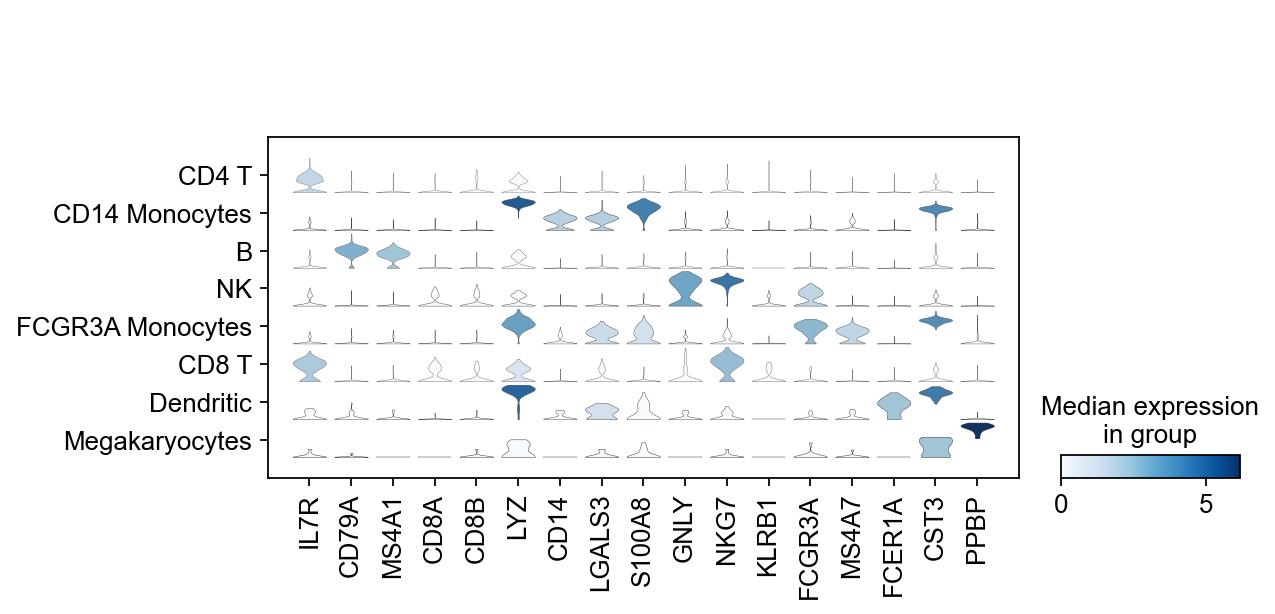

In [85]:
sc.pl.stacked_violin(adata, marker_genes, groupby='leiden', rotation=90)

In [86]:
#Number of genes/cells
adata.X.shape

(2638, 1838)

## Assigning cell types to unnormalized adata:

In [87]:
adata_copy.obs["cell_types"] = adata.obs["leiden"]
adata_copy.obs["scpred_CellType"] = adata.obs["leiden"]

In [88]:
#and swithcing to only using adata without normalization
adata = adata_copy

As it is recommended in deconvolution methods, we will delete cells that have low quantities (<50):

In [89]:
Counter(adata.obs["scpred_CellType"])

Counter({'CD8 T': 163,
         'B': 342,
         'CD4 T': 1131,
         'FCGR3A Monocytes': 200,
         'NK': 317,
         'CD14 Monocytes': 436,
         'Dendritic': 36,
         'Megakaryocytes': 13})

In [90]:
# remove cells that are unlabeled or unclassified
cell_type_id = adata.obs["scpred_CellType"].values
cell_type_id = np.unique(cell_type_id)
cell_type_remove = ["Dendritic", "Megakaryocytes"]
cell_type_id = set(cell_type_id).difference(set(cell_type_remove))
adata = adata[adata.obs["scpred_CellType"].isin(cell_type_id)]
#matching obs
adata.obs["cell_types"] = adata.obs["scpred_CellType"]
print(np.unique(adata.obs["scpred_CellType"].values))

Trying to set attribute `.obs` of view, copying.


['B' 'CD14 Monocytes' 'CD4 T' 'CD8 T' 'FCGR3A Monocytes' 'NK']


Visualize cell types:

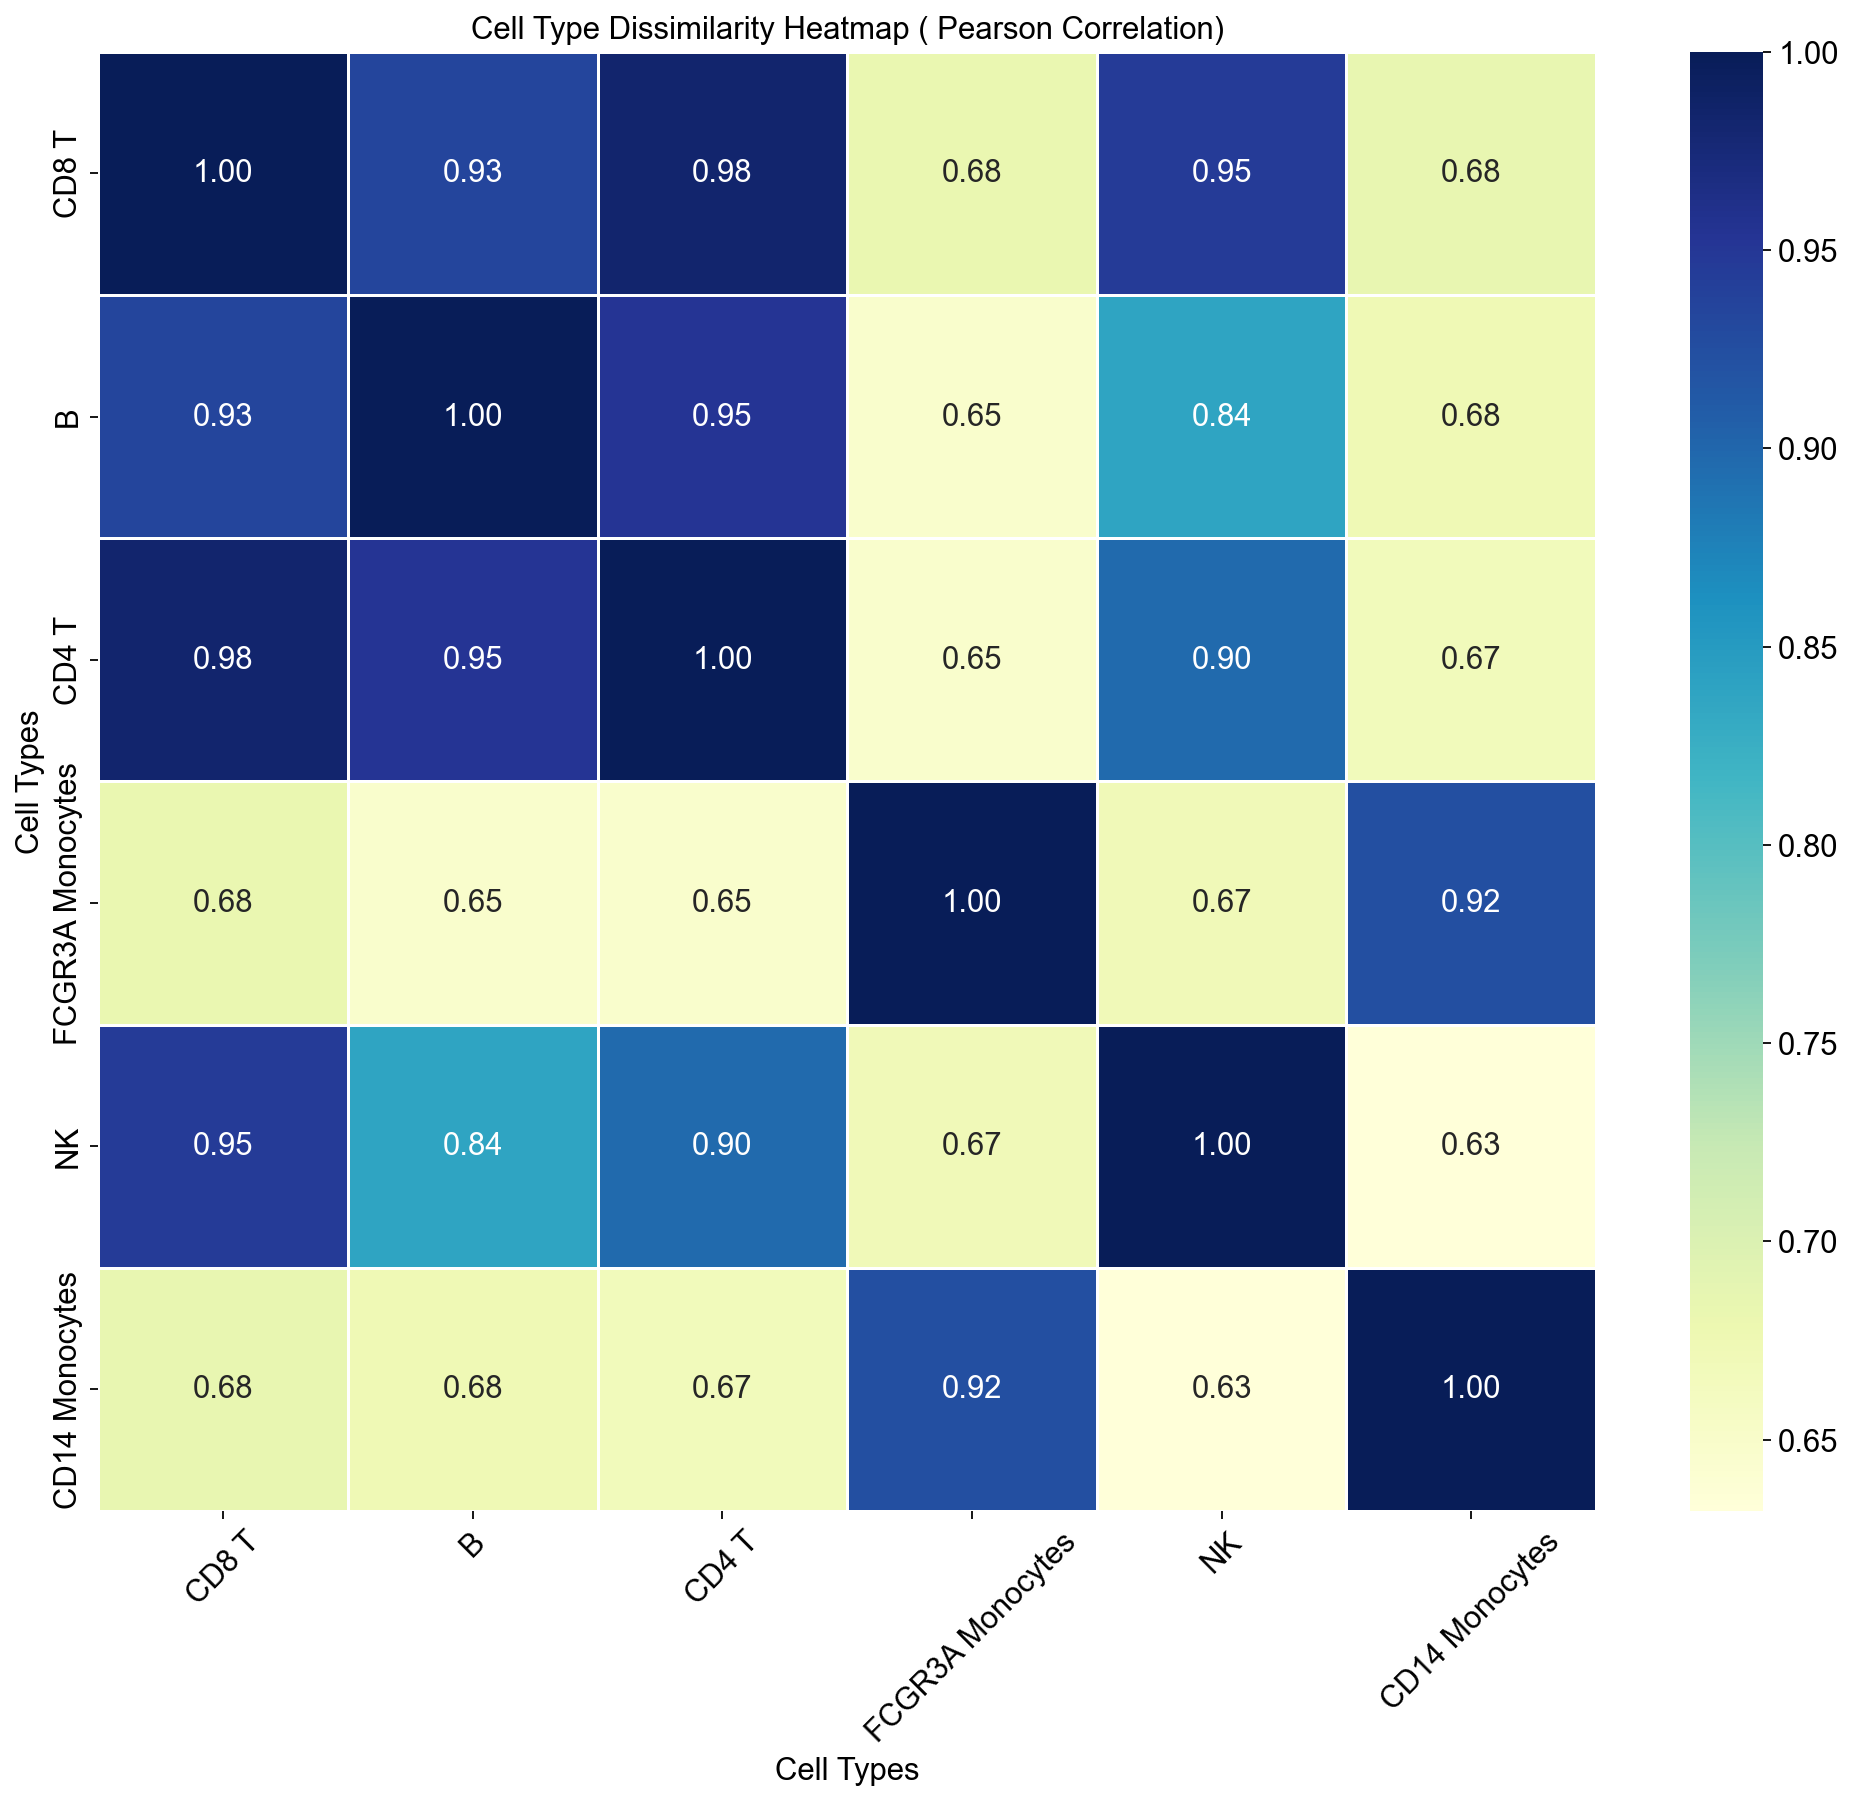

In [91]:
# Define the number of samples for resampling
num_samples = 50000

# Making cell type reference without scaling
cell_types = adata.obs["cell_types"].unique()
gene_ids = adata.var["gene_ids"]
ref_raw = pd.DataFrame(index=gene_ids, columns=cell_types)

for cell_type in cell_types:
    cell_df = adata[adata.obs["cell_types"].isin([cell_type])]
    cell_sample = resample(cell_df, n_samples=num_samples, replace=True)
    x = cell_sample.X.sum(axis=0)
    sum_over_genes = pd.DataFrame(x).T
    ref_raw[cell_type] = sum_over_genes.values

# Calculate Pearson correlations
correlation_matrix = ref_raw.corr()

# Create a DataFrame for the similarity matrix
cell_types_similarity =correlation_matrix  # Convert correlations to dissimilarities
similarity_df = pd.DataFrame(cell_types_similarity, columns=cell_types, index=cell_types)

# Create a heatmap to visualize the similarities
plt.figure(figsize=(15, 12))
sns.heatmap(similarity_df, cmap="YlGnBu", annot=True, fmt=".2f", linewidths=0.5)
plt.title("Cell Type Dissimilarity Heatmap ( Pearson Correlation)")
plt.xlabel("Cell Types")
plt.ylabel("Cell Types")
plt.xticks(rotation=45)
plt.show()

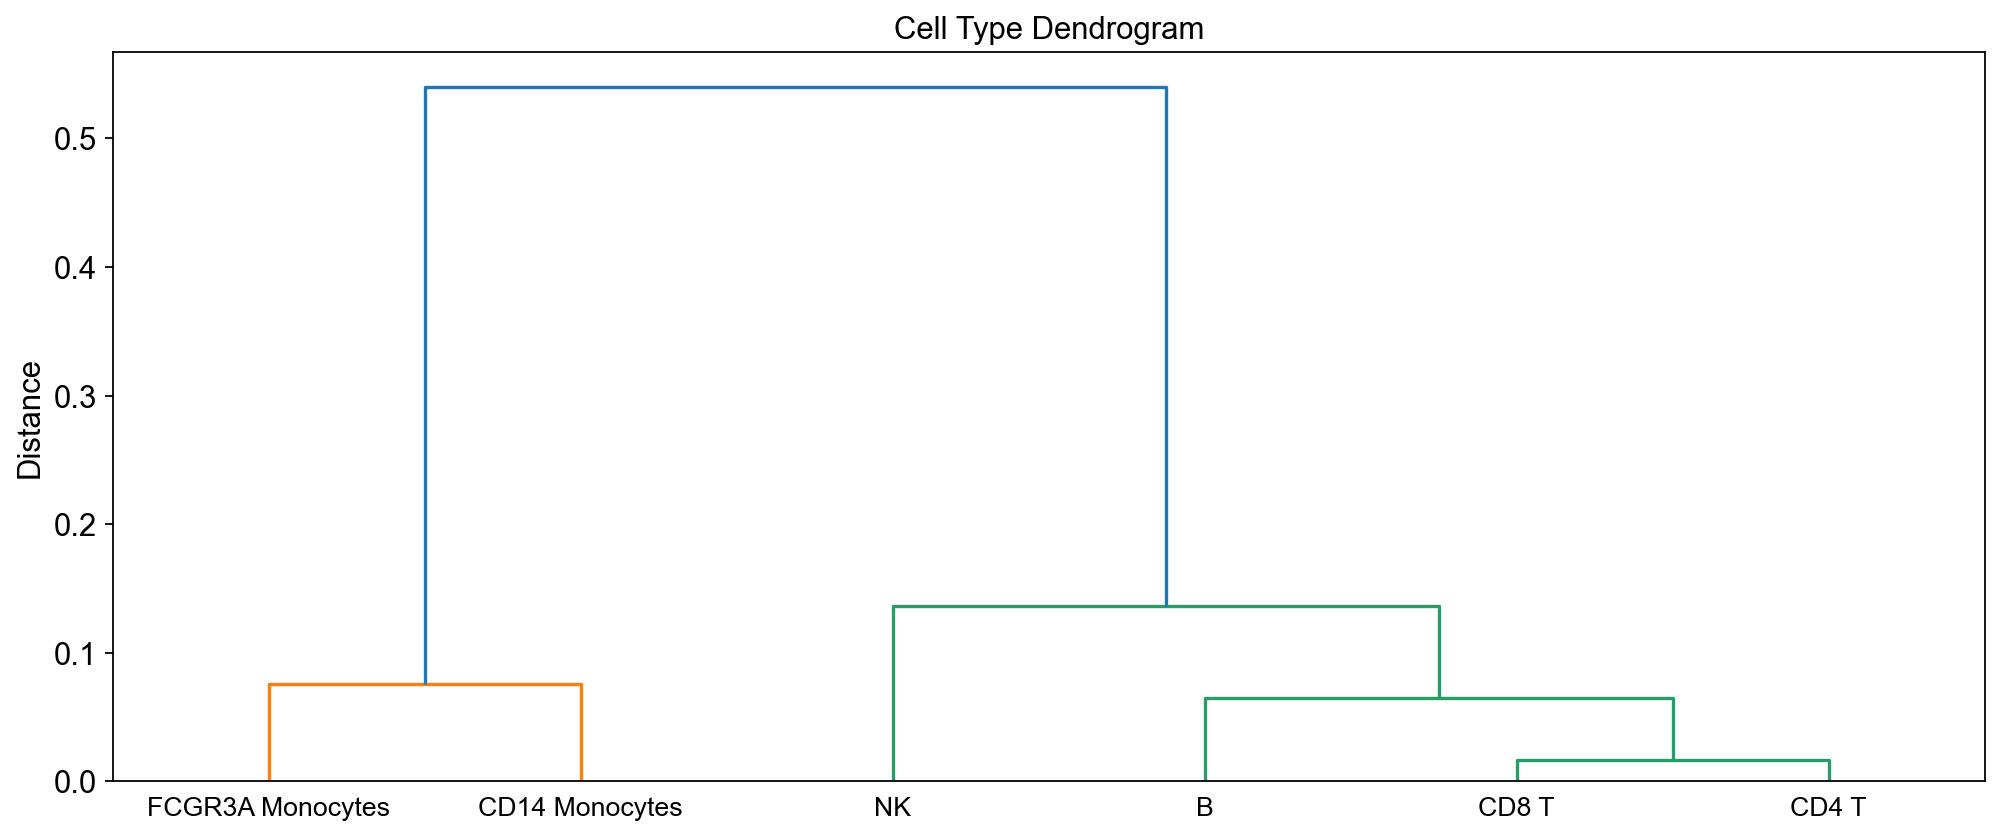

In [95]:
# Calculate Pearson correlations
correlation_matrix = ref_raw.corr()

# Create a DataFrame for the similarity matrix
cell_types_similarity = 1 - correlation_matrix  # Convert correlations to dissimilarities
similarity_df = pd.DataFrame(cell_types_similarity, columns=cell_types, index=cell_types)

# Create a dendrogram to visualize hierarchical clustering
linkage_matrix = linkage(squareform(cell_types_similarity), method='ward')
plt.figure(figsize=(15, 6))
dendrogram(linkage_matrix, labels=cell_types, orientation='top')
plt.title("Cell Type Dendrogram")
plt.ylabel("Distance")
plt.grid(False)
plt.show()

In [38]:
#saving for later adata as anndata without normalization
adata_path_ = os.path.join(adata_path, f"{res_name}_adata_notlog.h5ad")
adata_path_ = Path(adata_path_)
adata.write_h5ad(adata_path_)

## **Pseudobulk-creating loops:**
1. All Cell Types, Noise added
2. All Cell Types, No noise added

Run all or one at a time as needed.

In [39]:
#assigning cell types to untransformed data
sn_adata = adata.copy()
Counter(sn_adata.obs["scpred_CellType"])

Counter({'0': 1174, '3': 341, '1': 486, '2': 438, '4': 150, '5': 36, '6': 13})

In [40]:
# no specific cell noise 
len_vector = sn_adata.obs["cell_types"].unique().shape[0]
cell_noise = [np.random.lognormal(0, 0, sn_adata.var['gene_ids'].shape[0]) for i in range(len_vector)]

# cell type order
cell_order = sn_adata.obs.cell_types.unique()
num_random = 200 #number of random pseudos

#adding cell types to both
sn_adata.obs['scpred_CellType'] = sn_adata.obs["cell_types"] #to match var name in functions
#custom proportion of equal prop / cell
num_cells = len_vector
custom_prop = np.array([(1/num_cells)]*num_cells)
custom_prop  =  pd.DataFrame(custom_prop).T
custom_prop.columns = cell_order
custom_prop

0         3         1         2         4         5         6
0  0.142857  0.142857  0.142857  0.142857  0.142857  0.142857  0.142857

All Cell Types, No Noise:

In [41]:
sampling_adata = sn_adata
num_cells = 5000
num_random = 200
noise_type = "No noise" #to create noise
sample_noise = None
if make_pseudos:  
        for idx in range(0,10):
                print(f"**idx {idx}**")
                ###########################################################################################################
                ### CALC REALISTIC CELL TYPE PROPORTIONS AND CELL TYPE SPECIFIC
                ###########################################################################################################

                # calculate the reall cell type proportion
                curr_real_prop =  sn_sc_preprocess.calc_prop(sampling_adata, cell_order=cell_order)

                # make the cell type proportion matrix
                curr_prop_df = sn_sc_preprocess.get_corr_prop_matrix(num_samp=200, 
                                                                        real_prop=curr_real_prop.values.tolist()[0],
                                                                        cell_order=cell_order, 
                                                                        min_corr=0.95)
                # get the single cell type proportions
                ct_prop_df = sn_sc_preprocess.get_single_celltype_prop_matrix(num_samp=50,
                                                                                cell_order=cell_order)

                # put them together
                curr_prop_df = curr_prop_df.append(ct_prop_df)

                ########################################################
                ### MAKE PSEUDOBULKS FOR ^^^ PROPS 
                ########################################################
                # now get the pseudobulks for both realistic and cell type specific
                prop_df, pseudobulks_df, sample_noise = sn_sc_preprocess.use_prop_make_sum(sampling_adata,  
                                                                        num_cells=num_cells, 
                                                                        props_vec=curr_prop_df, 
                                                                        cell_noise=cell_noise, #no cell noise
                                                                        sample_noise=sample_noise, noise_type = noise_type)

                # make the proportions instead of cell counts
                prop_df = prop_df.div(prop_df.sum(axis=1), axis=0)
                
                ###########################################################################################################
                ######   NOW THE RANDOM PROPS AND PSEUDOS  ############################
                ###########################################################################################################
                
                prop_df_new, pseudobulk_df_new, test_prop, test_expr =  sn_sc_preprocess.make_prop_and_sum(sampling_adata, 
                                                                        num_samples = num_random, 
                                                                        num_cells = num_cells, 
                                                                        use_true_prop = False, 
                                                                        cell_noise = cell_noise, #no cell noise
                                                                        sample_noise = sample_noise, noise_type = noise_type)
                                                                        
                # make the proportions instead of cell counts
                prop_df_new = prop_df_new.div(prop_df_new.sum(axis=1), axis=0)

                # put them together with the others
                prop_df = prop_df.append(prop_df_new)
                pseudobulks_df = pseudobulks_df.append(pseudobulk_df_new)

                ###########################################################################################################
                ### MAKE THE EQUAL PROPORTION PSEUDOS (almost equal)  ##############
                ###########################################################################################################

                # make the cell type proportion matrix  
                curr_prop_df_EQ = sn_sc_preprocess.get_prop_matrix_wnoise(custom_prop, num_bulks = 200)

                # now get the pseudobulks
                prop_df_EQ, pseudobulks_df_EQ, sample_noise = sn_sc_preprocess.use_prop_make_sum(sampling_adata,  
                                                                        num_cells=num_cells, 
                                                                        props_vec=curr_prop_df_EQ, 
                                                                        cell_noise=cell_noise, #no cell noise
                                                                        sample_noise=sample_noise, noise_type = noise_type)


                # make the proportions instead of cell counts
                prop_df_EQ = prop_df_EQ.div(prop_df_EQ.sum(axis=1), axis=0)

                # put them together with the rest of props and psuedos:
                prop_df = prop_df.append(prop_df_EQ)
                pseudobulks_df = pseudobulks_df.append(pseudobulks_df_EQ)

                ###########################################################################################################
                #######  SAVING   #################################################################################
                ###########################################################################################################

                pseudobulk_file = os.path.join(aug_data_path, f"{res_name}_nonoise_pseudo_{idx}.pkl")
                prop_file = os.path.join(aug_data_path, f"{res_name}_nonoise_prop_{idx}.pkl")

                pseudobulk_path = Path(pseudobulk_file)
                prop_path = Path(prop_file)

                pickle.dump( prop_df, open( prop_path, "wb" ) )
                pickle.dump( pseudobulks_df, open( pseudobulk_path, "wb" ) )

All Cell Types, Noise:

In [42]:
sampling_adata = sn_adata
num_cells = 5000
num_random = 200
noise_type = "No sample noise"
sample_noise = None
if make_pseudos:  
        for idx in range(0,10):
                noise_type = "No sample noise"
                print(f"**idx {idx}**")
                ###########################################################################################################
                ### CALC REALISTIC CELL TYPE PROPORTIONS AND CELL TYPE SPECIFIC
                ###########################################################################################################

                # calculate the real cell type proportion
                curr_real_prop =  sn_sc_preprocess.calc_prop(sampling_adata, cell_order=cell_order)

                # make the cell type proportion matrix
                curr_prop_df = sn_sc_preprocess.get_corr_prop_matrix(num_samp=200, 
                                                                        real_prop=curr_real_prop.values.tolist()[0],
                                                                        cell_order=cell_order, 
                                                                        min_corr=0.95)
                # get the single cell type proportions
                ct_prop_df = sn_sc_preprocess.get_single_celltype_prop_matrix(num_samp=50,
                                                                                cell_order=cell_order)

                # put them together
                curr_prop_df = curr_prop_df.append(ct_prop_df)

                ########################################################
                ### MAKE PSEUDOBULKS FOR ^^^ PROPS 
                ########################################################
                # now get the pseudobulks for both realistic and cell type specific
                prop_df, pseudobulks_df, sample_noise = sn_sc_preprocess.use_prop_make_sum(sampling_adata,  
                                                                        num_cells=num_cells, 
                                                                        props_vec=curr_prop_df, 
                                                                        cell_noise=cell_noise, #no cell noise
                                                                        sample_noise=sample_noise, noise_type=noise_type)

                # make the proportions instead of cell counts
                prop_df = prop_df.div(prop_df.sum(axis=1), axis=0)
                
                ###########################################################################################################
                ######   NOW THE RANDOM PROPS AND PSEUDOS  ############################
                ###########################################################################################################
                
                prop_df_new, pseudobulk_df_new, test_prop, test_expr =  sn_sc_preprocess.make_prop_and_sum(sampling_adata, 
                                                                        num_samples = num_random, 
                                                                        num_cells = num_cells, 
                                                                        use_true_prop = False, 
                                                                        cell_noise = cell_noise, #no cell noise
                                                                        sample_noise = sample_noise, noise_type=noise_type)
                                                                        
                # make the proportions instead of cell counts
                prop_df_new = prop_df_new.div(prop_df_new.sum(axis=1), axis=0)

                # put them together with the others
                prop_df = prop_df.append(prop_df_new)
                pseudobulks_df = pseudobulks_df.append(pseudobulk_df_new)

                ###########################################################################################################
                ### MAKE THE EQUAL PROPORTION PSEUDOS (almost equal)  ##############
                ###########################################################################################################

                # make the cell type proportion matrix  
                curr_prop_df_EQ = sn_sc_preprocess.get_prop_matrix_wnoise(custom_prop, num_bulks = 200)

                # now get the pseudobulks
                prop_df_EQ, pseudobulks_df_EQ, sample_noise = sn_sc_preprocess.use_prop_make_sum(sampling_adata,  
                                                                        num_cells=num_cells, 
                                                                        props_vec=curr_prop_df_EQ, 
                                                                        cell_noise=cell_noise, #no cell noise
                                                                        sample_noise=sample_noise, noise_type=noise_type)


                # make the proportions instead of cell counts
                prop_df_EQ = prop_df_EQ.div(prop_df_EQ.sum(axis=1), axis=0)

                # put them together with the rest of props and psuedos:
                prop_df = prop_df.append(prop_df_EQ)
                pseudobulks_df = pseudobulks_df.append(pseudobulks_df_EQ)

                ###########################################################################################################
                #######  SAVING   #################################################################################
                ###########################################################################################################

                pseudobulk_file = os.path.join(aug_data_path, f"{res_name}_noise_pseudo_{idx}.pkl")
                prop_file = os.path.join(aug_data_path, f"{res_name}_noise_prop_{idx}.pkl")

                pseudobulk_path = Path(pseudobulk_file)
                prop_path = Path(prop_file)

                pickle.dump( prop_df, open( prop_path, "wb" ) )
                pickle.dump( pseudobulks_df, open( pseudobulk_path, "wb" ) )

In [43]:
# write out the gene ids in intersection file
genes_all = sn_adata.var["gene_ids"]
gene_out_file = os.path.join(aug_data_path, f"{res_name}_intersection_genes.pkl")
gene_out_path = Path(gene_out_file)
pickle.dump( genes_all, open(gene_out_path, "wb" ) )

## **QC Pseudobulks Made:**

In [44]:
num_cell_type_specific = 50 * int(sn_adata.obs["cell_types"].unique().shape[0])
num_bulks = 200+num_cell_type_specific+200+200
num_bulks

950

In [45]:
X_full, Y_full, gene_df, meta_df= sn_sc_preprocess.read_all_pseudobulk_files(data_path=aug_data_path,
                noise_type= "nonoise_", file_name = res_name, num_bulks_training = num_bulks, 
                num_files=10, random_selection=False)

0
1
2
3
4
5


6
7
8
9


(9000, 2)
(9000, 2)


/var/folders/d3/x10lxf7x1n37__s3n36qxmlw0000gp/T/ipykernel_65314/3825135697.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


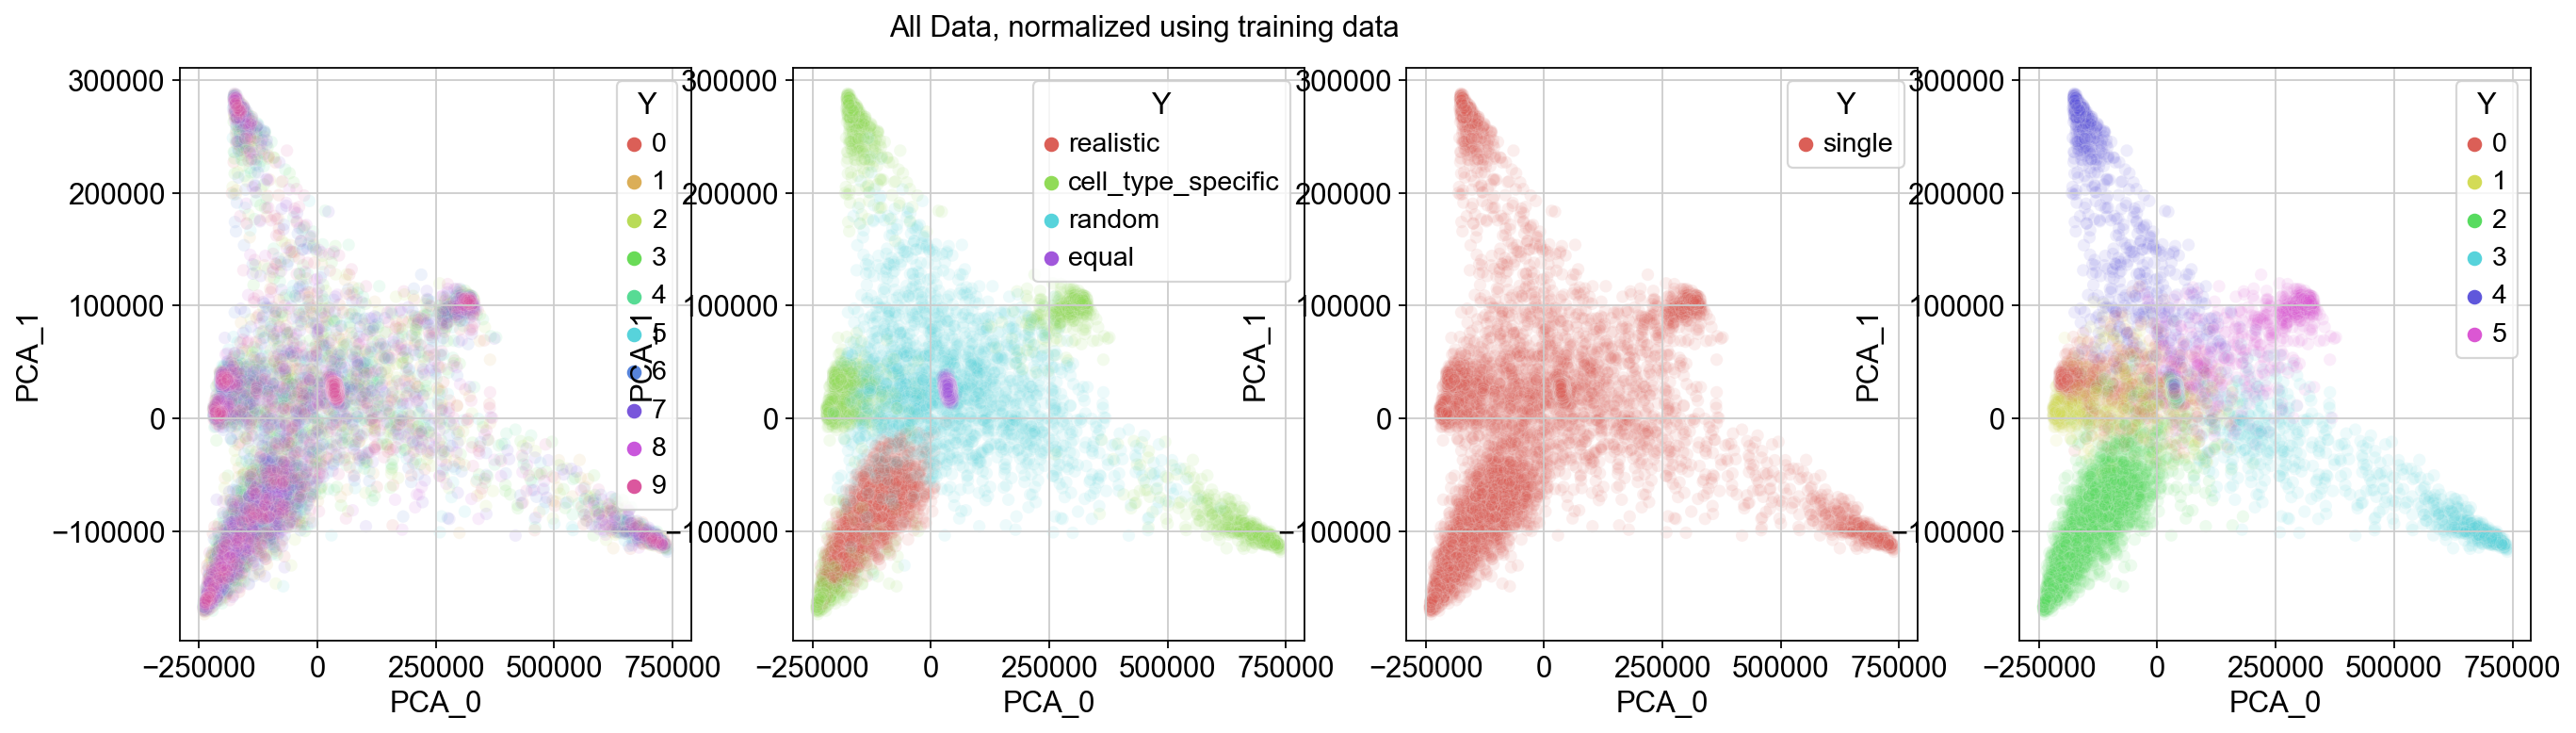

In [46]:
## plot samples
plot_df = vp.get_pca_for_plotting(X_full)

fig, axs = plt.subplots(1, 4, figsize=(20,5))

Y_temp = np.copy(Y_full)
Y_temp = np.argmax(Y_temp, axis=1) 

vp.plot_pca(plot_df, meta_df.sample_id.to_numpy(), axs[0], title=f"")
vp.plot_pca(plot_df, meta_df.cell_prop_type.to_numpy(), axs[1], title=f"")
vp.plot_pca(plot_df, meta_df.samp_type.to_numpy(), axs[2], title=f"")
vp.plot_pca(plot_df, Y_temp, axs[3], title=f"")

fig.suptitle("All Data, normalized using training data", fontsize=14)

fig.show()

/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 9000 samples in 0.024s...
[t-SNE] Computed neighbors for 9000 samples in 9.371s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9000
[t-SNE] Computed conditional probabilities for sample 2000 / 9000
[t-SNE] Computed conditional probabilities for sample 3000 / 9000
[t-SNE] Computed conditional probabilities for sample 4000 / 9000
[t-SNE] Computed conditional probabilities for sample 5000 / 9000
[t-SNE] Computed conditional probabilities for sample 6000 / 9000
[t-SNE] Computed conditional probabilities for sample 7000 / 9000
[t-SNE] Computed conditional probabilities for sample 8000 / 9000
[t-SNE] Computed conditional probabilities for sample 9000 / 9000
[t-SNE] Mean sigma: 3582.579796
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.470108
[t-SNE] KL divergence after 500 iterations: 1.501302
(9000, 2)
(9000, 2)


/var/folders/d3/x10lxf7x1n37__s3n36qxmlw0000gp/T/ipykernel_65314/1906434642.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


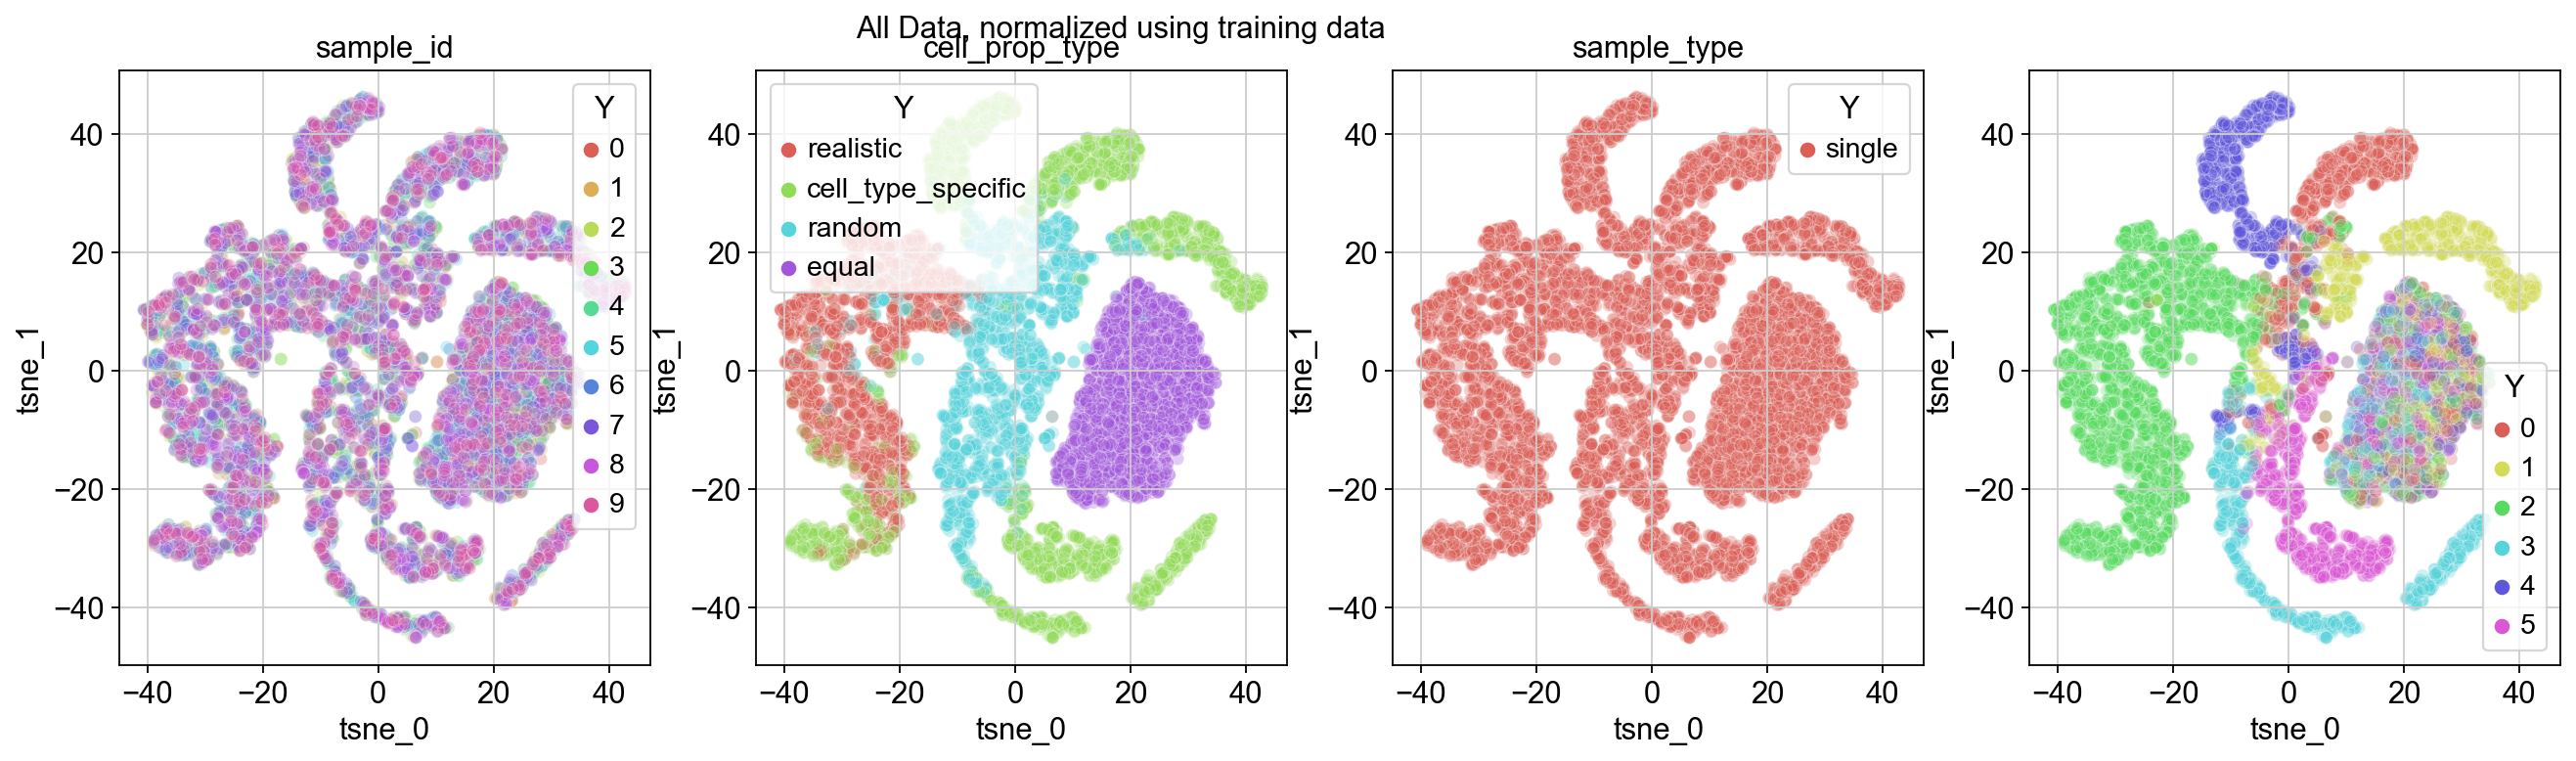

In [47]:
## plot samples
plot_df = vp.get_tsne_for_plotting(X_full)

fig, axs = plt.subplots(1, 4, figsize=(20,5))

Y_temp = np.copy(Y_full)
Y_temp = np.argmax(Y_temp, axis=1) 

vp.plot_tsne(plot_df, meta_df.sample_id.to_numpy(), axs[0], title=f"sample_id")
vp.plot_tsne(plot_df, meta_df.cell_prop_type.to_numpy(), axs[1], title=f"cell_prop_type")
vp.plot_tsne(plot_df, meta_df.samp_type.to_numpy(), axs[2], title=f"sample_type")
vp.plot_tsne(plot_df, Y_temp, axs[3], title=f"")

fig.suptitle("All Data, normalized using training data", fontsize=14)

fig.show()

## **CibersortX Preparation:**
This is run to get the cell specific barcode genes from CIBERSORTx.

In [48]:
if prep_cibersort:
    #and as anndata object
    adata_path_ = os.path.join(aug_data_pathdata_path, f"{res_name}_adata_notlog.h5ad")
    print(adata_path_)
    adata_path_ = Path(adata_path_)
    sn_adata_copy = sc.read_h5ad(adata_path_)
    print(Counter(sn_adata_copy.obs.cell_types))

Deleting cells in large cell types to be able to run CIBERSORTx in web:
(data is too large otherwise)

If running CIBERSORTx in Docker, no need to limit cell types.

In [49]:
if prep_cibersort:
    if limit_celltypes:

        #dreate a mask to identify cells from the cell types to limit
        mask_to_limit = sn_adata_copy.obs["cell_types"].isin(cell_types_to_limit)

        #create a mask for the remaining cell types
        mask_remaining = ~mask_to_limit

        #initialize a dictionary to keep track of removed cells per cell type
        removed_cells_count = {cell_type: 0 for cell_type in cell_types_to_limit}

        #initialize arrays to store new observations and filtered indices
        new_obs = []
        filtered_indices = []

        #iterate through each cell in the original sn_adata object
        for cell_idx, cell_type in enumerate(sn_adata_copy.obs["cell_types"]):
            if cell_type in cell_types_to_limit:
                removed_count = removed_cells_count.get(cell_type, 0)
                if removed_count < max_cells_per_type:
                    removed_cells_count[cell_type] = removed_count + 1
                    filtered_indices.append(cell_idx)

        #create a new AnnData object with the filtered cells
        filtered_sn_adata = sc.AnnData(
            X=sn_adata_copy.X[filtered_indices],
            obs=sn_adata_copy.obs.iloc[filtered_indices],
            var=sn_adata_copy.var
        )

        #cppend the remaining cell types to the filtered sn_adata object
        filtered_sn_adata = filtered_sn_adata.concatenate(
            sn_adata_copy[mask_remaining],
            join="outer"
        )
        #QC
        print(Counter(filtered_sn_adata.obs.cell_types))

In [50]:
if limit_celltypes:
    sn_adata_copy = filtered_sn_adata.copy()

In [51]:
if prep_cibersort:
    dense_matrix = sn_adata_copy.X.todense()

    sc_profile_file = os.path.join(aug_data_path, f"{res_name}_sig.pkl")
    sc_profile_path = Path(sc_profile_file)

    dense_df = pd.DataFrame(dense_matrix, columns = sn_adata_copy.var_names)
    dense_df.insert(loc=0, column='cell_types', value=sn_adata_copy.obs["cell_types"].to_list())
    #save file
    pickle.dump( dense_df, open( sc_profile_path, "wb" ) )
    #qc
    sig_df_sn = dense_df
    sig_df_sn.shape

    X_full.columns = sn_adata_copy.var_names

In [52]:
if prep_cibersort:
    #cut to only the random samples
    X_full.index = meta_df.index
    # # now we import all bulks and transpose
    X_train = X_full.transpose()
    X_train.columns = range(X_train.shape[1])

In [53]:
if prep_cibersort:
    #details
    exp_id = f"{res_name}"
    patient_idx =f"0"
    #and create files for CIBERSORTX
    mix_sn, sig_sn = sn_sc_preprocess.write_cs_bp_files(cibersort_path, exp_id, 
                        sig_df_sn, X_train, patient_idx)